### Denoising an Image

By popular request, here is an example notebook on denoising images.

Denoising by linear models (e.g. via DFT and filtering the spectrum) is difficult as it tends to destroy sharp edges in the images. A popular model for denoising is the ROF model (Rudin-Osher-Fatemi, 1992).  In this model we minimise an objective 
$$
   \Phi(u) = \int_\Omega |u - y|^2 + \lambda |\nabla u| \, dx,
$$
where $y$ represents the noisy image and $u$ the reconstructed image, while $\lambda$ is a fudge parameter. The idea behind the $|\nabla u|$ term is that it encourages smooth fields and even jumps are not unduly penalised i.e. even piecewise smooth $u$ will have a moderate $\|\nabla u\|_{L^1}$ norm, while their $\|\nabla u\|_{L^2}$-norm will be large or infinite. Oscillations (noise) on the other hand are heavily penalized. 

Minimising this functional is theoretically trivial since it is convex, but computationally challenging since it is non-smooth. 

As a first example we show the denoising of a 1D signal, for which a very good Julia package exists.

In [1]:
using Images, FileIO

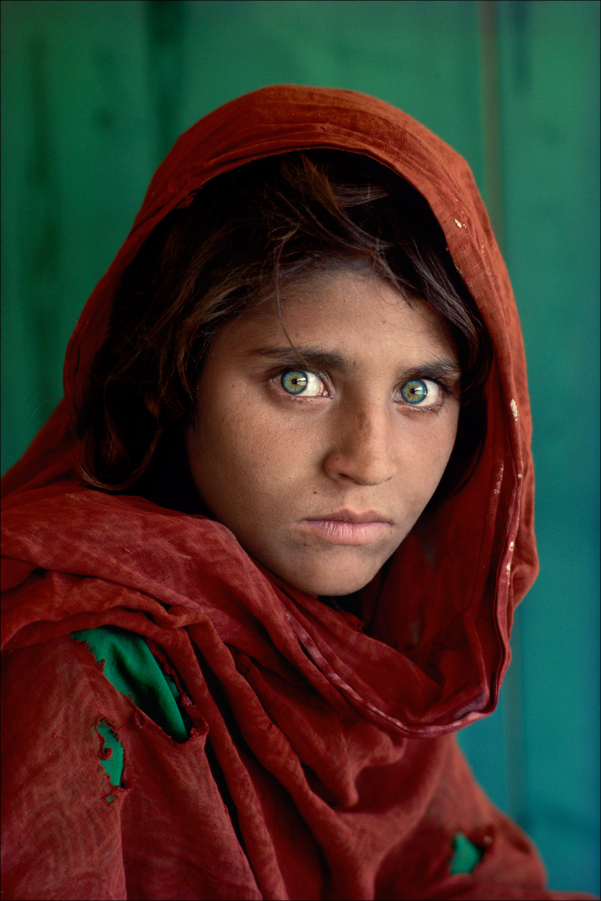

In [2]:
# The famous Afghan Girl (National Geographic, 1984)
img = RGB.(load("SharbatGula.jpg"))
# or a scenic view of Vancouver?
# img = RGB.(load("Vancouver.jpg"))

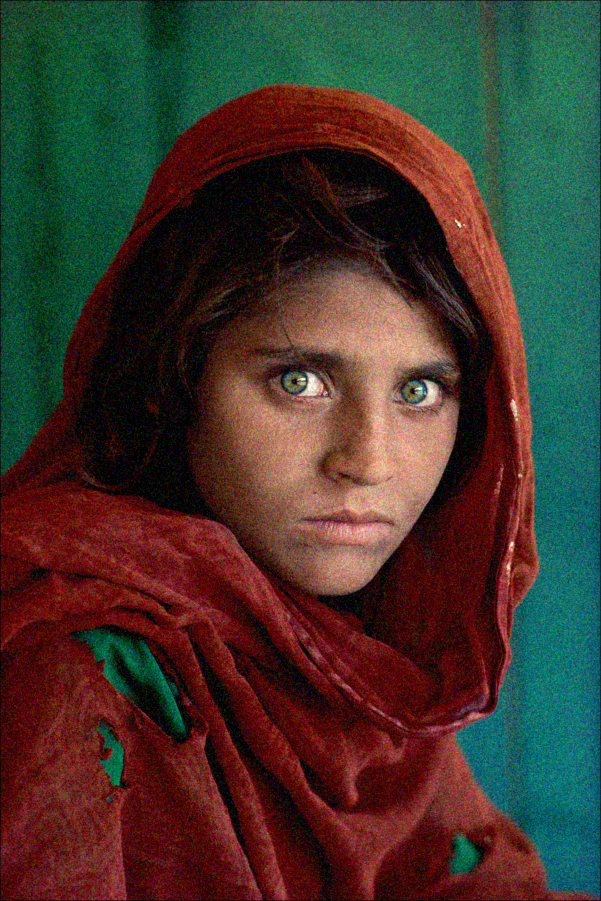

In [4]:
# a noisy version of the image 
red(img) = Float64[c.r for c in img]
blue(img) = Float64[c.b for c in img]
green(img) = Float64[c.g for c in img]
noisify(img, s) = noisify(red(img), green(img), blue(img), s)
noisify(r, g, b, s) = RGB.(r+2*s*(rand(size(r)...).-0.5), 
                           g+2*s*(rand(size(r)...).-0.5), 
                           b+2*s*(rand(size(r)...).-0.5))
noisy = noisify(img, 0.3)

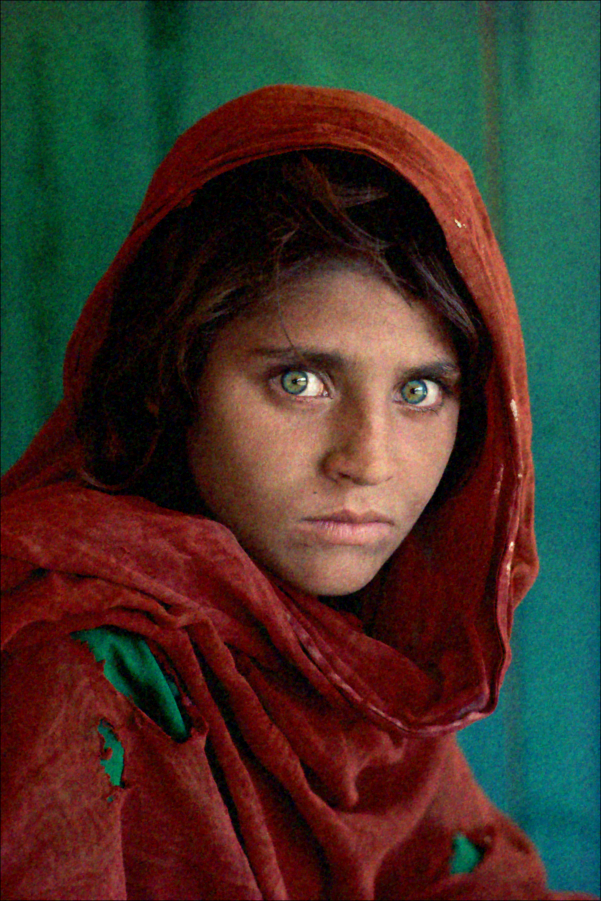

In [5]:
img1 = Images.imROF(noisy, 0.1, 30)

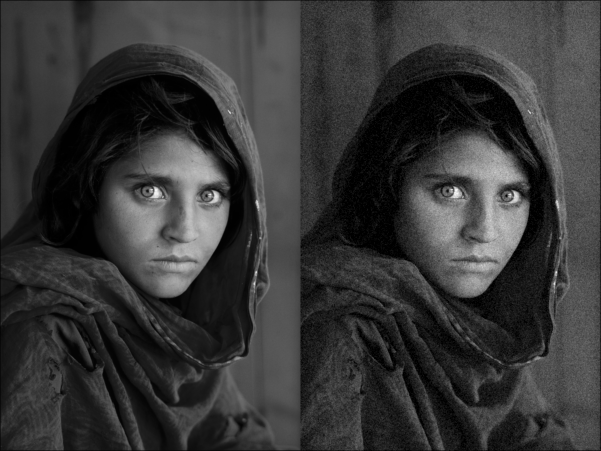

In [86]:
# Let's try and do this again by hand to understand what is involved 
# convert to grayscale to make our life a little easier 
togray(c) = 0.3 * c.r + 0.59 * c.g + 0.11 * c.b
A = togray.(img)
B = A + 0.5 * (rand(size(A)...) .- 0.5)
Gray.([A B])

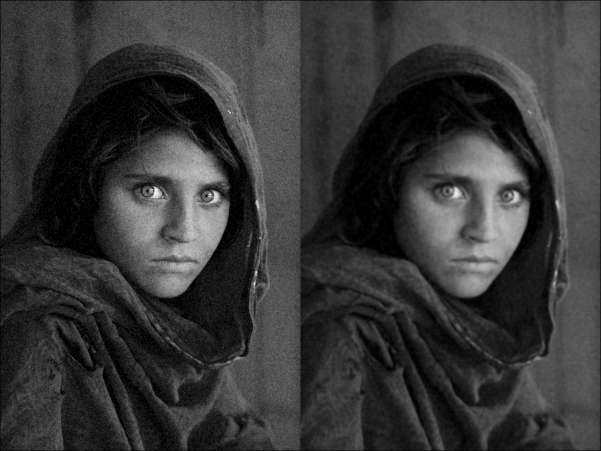

In [89]:
λ, g, dt, numiter = 1.0, 1, 0.25, 25 
im_h, im_w = size(A)
p = zeros(im_h, im_w, 2)
d = zeros(im_h, im_w, 2)
du = zeros(im_h, im_w, 2)
div_p = zeros(im_h, im_w)
u = zeros(im_h, im_w)

for i = 1:numiter
    # update the divergence operator 
    for x = 1:im_w, y = 2:im_h-1
        div_p[y,x] = p[y,x,1] - p[y-1,x,1]
    end
    for x = 2:im_w-1, y=1:im_h
        div_p[y,x] += p[y,x,2] - p[y,x-1,2]
    end
    # div operator on the boundary 
    div_p[:,1] .= p[:,1,2]
    div_p[:,im_w] .= -p[:,im_w-1,2]
    div_p[1,:] .= p[1,:,1]
    div_p[im_h,:] .= -p[im_h-1,:,1]

    # update step 
    @. u = B - λ * div_p
    # Calculate forward derivatives
    @. du[:,:,2] = u[:,[2:im_w; im_w]]-u;
    @. du[:,:,1] = u[[2:im_h; im_h],:]-u;
    # Iterate
    @. d[:,:,1] = (1 .+ (dt/λ/g).*abs.(sqrt.(du[:,:,1].^2 + du[:,:,2].^2)))
    @. d[:,:,2] = (1 .+ (dt/λ/g).*abs.(sqrt.(du[:,:,1].^2 + du[:,:,2].^2)))
    @. p = (p-(dt/λ).*du)./d;
end

B1 = u
Gray.([B B1])

Initial Error        = 2.9766156373270247
Output  Error [tv]   = 0.5873770739654571
Output  Error [gstv] = 0.3727821770026914


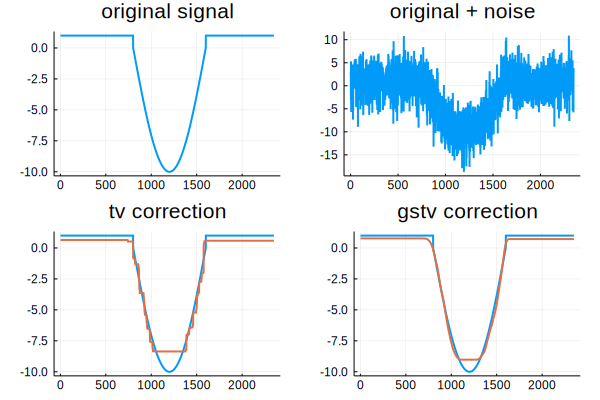

In [5]:
# below is a more modest example, but where we can see
# the limitations of this model very nicely 
# and explain the smearing effect 

using TotalVariation, Statistics, Plots

ground_truth = vcat(ones(800), -10 * sin.(range(0,pi,length=800)), ones(750))
noise        = 3*randn(length(ground_truth))
combined     = ground_truth .+ noise
gstv_out     = TotalVariation.gstv(combined, 40, 15.0)
tv_out       = TotalVariation.tv(combined, 200.0)

rms(s) = sqrt(mean((ground_truth.-s).^2))
println("Initial Error        = ", rms(combined))
println("Output  Error [tv]   = ", rms(tv_out))
println("Output  Error [gstv] = ", rms(gstv_out))

P1 = plot(ground_truth, label="", title="original signal", lw=2)
P2 = plot(combined, label="", title="original + noise", lw=2)
P3 = plot(ground_truth, label = "", title="tv correction", lw=2)
plot!(P3, tv_out, label = "", lw=2)
P4 = plot(ground_truth, label = "", title="gstv correction", lw=2)
plot!(P4, gstv_out, label = "", lw=2)

plot(P1, P2, P3, P4)